In [1]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt,pow,log
import matplotlib.cm as cm
from scipy.integrate import quad

In [2]:
!wget http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt
d = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
z = d.T[1]
mu = d.T[2]
errmu= d.T[3]
dlabel = 'SCP_2.1'
label = {"Z_SN":z,"DMdata_SN":mu,"Error_DM_SN":errmu}
data_SN=pd.DataFrame(label)
#print(data_SN)


URL transformed to HTTPS due to an HSTS policy
--2022-01-30 19:49:25--  https://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt
Resolving supernova.lbl.gov (supernova.lbl.gov)... 128.3.28.88
Connecting to supernova.lbl.gov (supernova.lbl.gov)|128.3.28.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33899 (33K) [text/plain]
Saving to: ‘SCPUnion2.1_mu_vs_z.txt.19’

SCPUnion2.1_mu_vs_z 100%[===================>]  33.10K   101KB/s    in 0.3s    

2022-01-30 19:49:27 (101 KB/s) - ‘SCPUnion2.1_mu_vs_z.txt.19’ saved [33899/33899]



In [3]:
#number of samples 
sampl= 10000
#number of pars
par = 2


# Number of Bins of the Supernova data 
snbins= 31
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02
H0=69.8

#Defining part which comes inside integeration of distance Luminosity


dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n):
    def int_func(x):
        return 1/((pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5)))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(300000/(H0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n):
        m=5*log(D_l(z,omega_m,n),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m, n):
    if(omega_m<=0.0):
        loglikely=-1.e100
    else:
        for i in range(len(z)):
            dmu[i]= mu[i]- mu_theory(z[i],omega_m,n)
        loglikely= -0.5*np.dot(dmu,dmu)
    return loglikely



#Empty array to store parameter values
# First Column = Omega_m
# Second Column = n

# A third parameter will be used to store the ln(likelihood) 

# Create a [1000,3] empty array
mcmc_arr= np.empty([sampl,par+1])

#Set initial likelyhood to a very low value so that next likelihood calculated is greater than 
#that and is accepted
#Filling up the first row of the three columns
mcmc_arr[0,0]= np.random.uniform()
mcmc_arr[0,1]= np.random.uniform()

#Calculate an initial likelyhood value and store it as the third column
mcmc_arr[0,2]=lnl(mcmc_arr[0,0], mcmc_arr[0,1])
accpt_nmbr=0

for i in range(1,sampl):
    lnl_prev= mcmc_arr[i-1,2]
    omega_m_next= np.random.normal(mcmc_arr[i-1,0],sigma_omega)
    n_next= np.random.normal(mcmc_arr[i-1,1],sigma_n)

    lnl_next= lnl(omega_m_next,n_next)

    #Now comes the Metropolis Hastings algorithm to accept or reject the newly calculated point
    # Accept the point if likelyhood has increased
    if(lnl_next>lnl_prev):
        mcmc_arr[i,0]= omega_m_next
        mcmc_arr[i,1]= n_next
        mcmc_arr[i,2]= lnl_next
        accpt_nmbr+=1
        #print("Accepted with a higher likelihood")
    else:
        x=np.random.uniform()
        #if not, we accept it with a lesser likelyhood defined by a threshold
        if(lnl_next-lnl_prev>np.log(x)): 
#This can be randomized everytime to select a different threshold, select a value x=np.random.uniform() 
#and take log(x)
            mcmc_arr[i,0]= omega_m_next
            mcmc_arr[i,1]= n_next
            mcmc_arr[i,2]= lnl_next
            accpt_nmbr+=1
            #print("Accepted with a lesser likelihood")
        else:
            mcmc_arr[i,0]= mcmc_arr[i-1,0]
            mcmc_arr[i,1]= mcmc_arr[i-1,1]
            mcmc_arr[i,2]= lnl_prev
            #print("This draw is rejected")




Estimated value of omega_m = 0.07768501903056126
Estimated value of n = 0.6563326950361267
Estimated value of standard deviation of omega_m = 0.05026317012560263
Estimated value of standard deviation of  n = 0.18564869551545177
Acceptance ratio is 91.37  percent


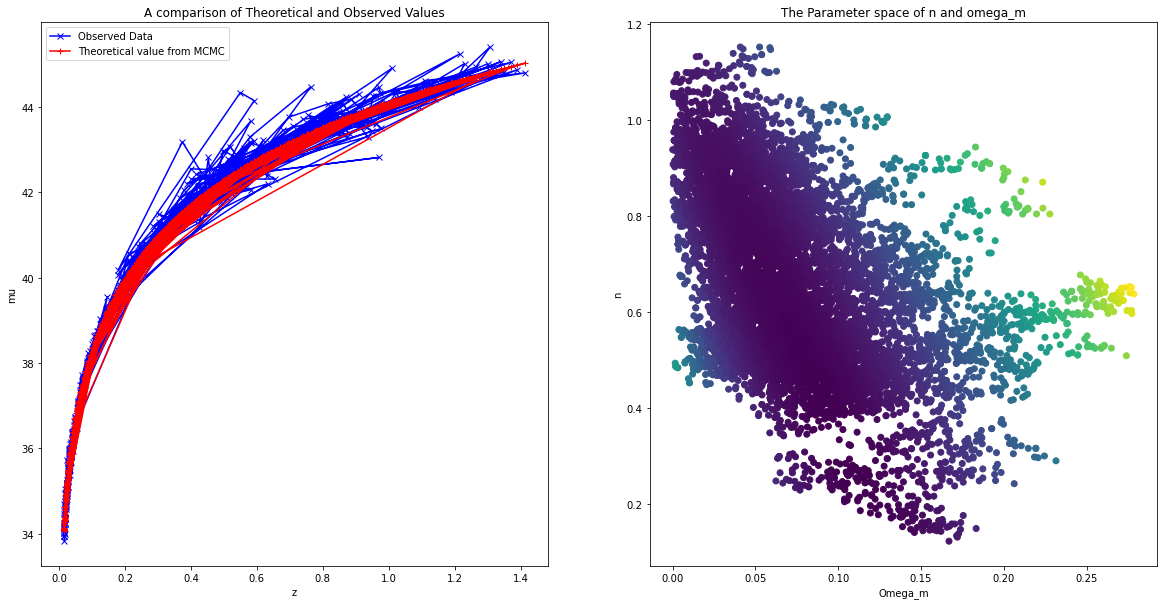

In [7]:
#For value calculation, we reject the initial values given by the algorithm so as to only select the values where the algorithm converges(as taught in class)
#Lets say we reject the initial 25% of the values
reject= sampl//25

print ('\n\n\nEstimated value of omega_m = '+ str(np.mean(mcmc_arr[reject:sampl,0])))
print ('Estimated value of n = '+ str(np.mean(mcmc_arr[reject:sampl,1])))
print ('Estimated value of standard deviation of omega_m = '+ str(np.std(mcmc_arr[reject:sampl,0])))
print ('Estimated value of standard deviation of  n = '+ str(np.std(mcmc_arr[reject:sampl,1])))
print ('Acceptance ratio is '+ str((accpt_nmbr*100)/sampl)+"  percent")

fig = plt.figure()
fig.set_size_inches(20,10)
#Plot the samples
ax1 = fig.add_subplot(121)
plt.xlabel("z")
plt.ylabel('mu')
plt.title("A comparison of Theoretical and Observed Values")
ax1.plot(z, mu, c='blue', marker='x',label="Observed Data")
ax2 = fig.add_subplot(122)
ax2.scatter(mcmc_arr[reject:,0], mcmc_arr[reject:,1],c = -mcmc_arr[reject:,2])
#plt.xlim(0.1,0.5)
#plt.ylim(0.6,0.8)
plt.xlabel("Omega_m")
plt.ylabel('n')


#To plot the z vs mu function for out theoretical values
y_theoretical=np.empty(len(z))
for i in range(len(z)):
    y_theoretical[i]= mu_theory(z[i], np.mean(mcmc_arr[reject:,0]), np.mean(mcmc_arr[reject:,1]))
ax1.plot(z, y_theoretical, c='red', marker='+',label="Theoretical value from MCMC")
ax1.legend()
plt.title("The Parameter space of n and omega_m")
plt.show() 
